In [1]:
from keras.layers import (
    Dense,
    Dropout,
    Flatten,
    Input,
    concatenate,
)
import shap
import ffnn_explainer as nne
import iso_forest_explainer as isoe
from keras.layers import Embedding
from keras.models import Model
from sklearn.ensemble import IsolationForest
from sklearn.model_selection import train_test_split
from shap import Explanation
from shap.plots import waterfall

2024-12-07 14:04:14.567567: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
/home/yuri/anaconda3/envs/hlt/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
shap.plots.initjs()

In [3]:
# prepare test dataset
X, y = shap.datasets.adult()
X_display, y_display = shap.datasets.adult(display=True)
dtypes = list(zip(X.dtypes.index, map(str, X.dtypes)))
for k, dtype in dtypes:
    if dtype == "float32":
        X[k] -= X[k].mean()
        X[k] /= X[k].std()
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=7)

In [4]:
# start building the model
input_els = []
encoded_els = []
for k, dtype in dtypes:
    input_els.append(Input(shape=(1,)))
    if dtype == "int8":
        e = Flatten()(Embedding(X_train[k].max() + 1, 1)(input_els[-1]))
    else:
        e = input_els[-1]
    encoded_els.append(e)
encoded_els = concatenate(encoded_els)
layer1 = Dropout(0.5)(Dense(100, activation="relu")(encoded_els))
out = Dense(1)(layer1)

2024-12-07 14:04:19.464596: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


In [5]:
# compile and fit the model
regression = Model(inputs=input_els, outputs=[out])
regression.compile(optimizer="adam", loss="binary_crossentropy")
regression.fit(
    [X_train[k].values for k, t in dtypes],
    y_train,
    epochs=10,
    batch_size=512,
    shuffle=True,
    validation_data=([X_valid[k].values for k, t in dtypes], y_valid),
)

Epoch 1/10
51/51 [==============================] - 2s 17ms/step - loss: 1.7833 - val_loss: 0.6346
Epoch 2/10
51/51 [==============================] - 1s 14ms/step - loss: 1.6280 - val_loss: 0.6760
Epoch 3/10
51/51 [==============================] - 1s 13ms/step - loss: 1.5177 - val_loss: 0.7755
Epoch 4/10
51/51 [==============================] - 0s 10ms/step - loss: 1.5076 - val_loss: 0.6396
Epoch 5/10
51/51 [==============================] - 0s 9ms/step - loss: 1.4358 - val_loss: 1.1848
Epoch 6/10
51/51 [==============================] - 0s 8ms/step - loss: 1.4305 - val_loss: 0.8329
Epoch 7/10
51/51 [==============================] - 1s 10ms/step - loss: 1.3391 - val_loss: 0.6254
Epoch 8/10
51/51 [==============================] - 0s 9ms/step - loss: 1.3430 - val_loss: 0.6330
Epoch 9/10
51/51 [==============================] - 0s 9ms/step - loss: 1.3275 - val_loss: 0.6349
Epoch 10/10
51/51 [==============================] - 0s 9ms/step - loss: 1.2284 - val_loss: 0.5472


In [6]:
# user defined function for SHAP
def f(X):
    return regression.predict([X[:, i] for i in range(X.shape[1])]).flatten()

In [7]:
# library example
explainer = shap.KernelExplainer(f, X.iloc[:50, :])
shap_values = explainer.shap_values(X.iloc[299, :], nsamples=50)
shap_values50 = explainer.shap_values(X.iloc[280:330, :], nsamples=50)

79/79 [==============================] - 0s 2ms/step


  0%|          | 0/50 [00:00<?, ?it/s]

79/79 [==============================] - 0s 3ms/step


  2%|▏         | 1/50 [00:00<00:25,  1.96it/s]

79/79 [==============================] - 0s 3ms/step


  4%|▍         | 2/50 [00:01<00:24,  1.97it/s]

79/79 [==============================] - 0s 4ms/step


  6%|▌         | 3/50 [00:01<00:26,  1.75it/s]

79/79 [==============================] - 0s 3ms/step


  8%|▊         | 4/50 [00:02<00:25,  1.80it/s]

79/79 [==============================] - 0s 3ms/step


 10%|█         | 5/50 [00:02<00:24,  1.84it/s]

79/79 [==============================] - 0s 2ms/step


 12%|█▏        | 6/50 [00:03<00:23,  1.87it/s]

79/79 [==============================] - 0s 4ms/step


 14%|█▍        | 7/50 [00:03<00:24,  1.78it/s]

79/79 [==============================] - 0s 3ms/step


 16%|█▌        | 8/50 [00:04<00:23,  1.77it/s]

79/79 [==============================] - 0s 3ms/step


 18%|█▊        | 9/50 [00:04<00:23,  1.77it/s]

79/79 [==============================] - 0s 3ms/step


 20%|██        | 10/50 [00:05<00:22,  1.81it/s]

79/79 [==============================] - 0s 3ms/step


 22%|██▏       | 11/50 [00:06<00:21,  1.79it/s]

79/79 [==============================] - 0s 3ms/step


 24%|██▍       | 12/50 [00:06<00:20,  1.83it/s]

79/79 [==============================] - 0s 3ms/step


 26%|██▌       | 13/50 [00:07<00:20,  1.80it/s]

79/79 [==============================] - 0s 3ms/step


 28%|██▊       | 14/50 [00:07<00:20,  1.78it/s]

79/79 [==============================] - 0s 3ms/step


 30%|███       | 15/50 [00:08<00:19,  1.78it/s]

79/79 [==============================] - 0s 2ms/step


 32%|███▏      | 16/50 [00:08<00:18,  1.81it/s]

79/79 [==============================] - 0s 2ms/step


 34%|███▍      | 17/50 [00:09<00:16,  2.02it/s]

79/79 [==============================] - 0s 4ms/step


 36%|███▌      | 18/50 [00:09<00:17,  1.84it/s]

79/79 [==============================] - 0s 3ms/step


 38%|███▊      | 19/50 [00:10<00:16,  1.84it/s]

79/79 [==============================] - 0s 4ms/step


 40%|████      | 20/50 [00:11<00:17,  1.70it/s]

79/79 [==============================] - 0s 2ms/step


 42%|████▏     | 21/50 [00:11<00:16,  1.79it/s]

79/79 [==============================] - 0s 3ms/step


 44%|████▍     | 22/50 [00:12<00:15,  1.83it/s]

79/79 [==============================] - 0s 3ms/step


 46%|████▌     | 23/50 [00:12<00:15,  1.75it/s]

79/79 [==============================] - 0s 3ms/step


 48%|████▊     | 24/50 [00:13<00:14,  1.75it/s]

79/79 [==============================] - 0s 3ms/step


 50%|█████     | 25/50 [00:13<00:14,  1.68it/s]

79/79 [==============================] - 0s 3ms/step


 52%|█████▏    | 26/50 [00:14<00:14,  1.66it/s]

79/79 [==============================] - 0s 4ms/step


 54%|█████▍    | 27/50 [00:15<00:13,  1.65it/s]

79/79 [==============================] - 0s 4ms/step


 56%|█████▌    | 28/50 [00:15<00:13,  1.63it/s]

79/79 [==============================] - 0s 3ms/step


 58%|█████▊    | 29/50 [00:16<00:12,  1.68it/s]

79/79 [==============================] - 0s 2ms/step


 60%|██████    | 30/50 [00:16<00:11,  1.78it/s]

79/79 [==============================] - 0s 3ms/step


 62%|██████▏   | 31/50 [00:17<00:10,  1.78it/s]

79/79 [==============================] - 0s 3ms/step


 64%|██████▍   | 32/50 [00:18<00:10,  1.76it/s]

79/79 [==============================] - 0s 5ms/step


 66%|██████▌   | 33/50 [00:18<00:10,  1.66it/s]

79/79 [==============================] - 0s 3ms/step


 68%|██████▊   | 34/50 [00:19<00:09,  1.65it/s]

79/79 [==============================] - 0s 3ms/step


 70%|███████   | 35/50 [00:19<00:09,  1.66it/s]

79/79 [==============================] - 0s 3ms/step


 72%|███████▏  | 36/50 [00:20<00:08,  1.73it/s]

79/79 [==============================] - 0s 2ms/step


 74%|███████▍  | 37/50 [00:21<00:07,  1.72it/s]

79/79 [==============================] - 0s 2ms/step


 76%|███████▌  | 38/50 [00:21<00:06,  1.80it/s]

79/79 [==============================] - 0s 4ms/step


 78%|███████▊  | 39/50 [00:22<00:06,  1.71it/s]

79/79 [==============================] - 0s 3ms/step


 80%|████████  | 40/50 [00:22<00:05,  1.68it/s]

79/79 [==============================] - 0s 2ms/step


 82%|████████▏ | 41/50 [00:23<00:04,  1.83it/s]

79/79 [==============================] - 0s 4ms/step


 84%|████████▍ | 42/50 [00:23<00:04,  1.73it/s]

79/79 [==============================] - 0s 3ms/step


 86%|████████▌ | 43/50 [00:24<00:04,  1.67it/s]

79/79 [==============================] - 0s 2ms/step


 88%|████████▊ | 44/50 [00:24<00:03,  1.80it/s]

79/79 [==============================] - 0s 2ms/step


 90%|█████████ | 45/50 [00:25<00:02,  1.90it/s]

79/79 [==============================] - 0s 4ms/step


 92%|█████████▏| 46/50 [00:26<00:02,  1.68it/s]

79/79 [==============================] - 0s 4ms/step


 94%|█████████▍| 47/50 [00:26<00:01,  1.69it/s]

79/79 [==============================] - 0s 3ms/step


 96%|█████████▌| 48/50 [00:27<00:01,  1.69it/s]

79/79 [==============================] - 0s 3ms/step


 98%|█████████▊| 49/50 [00:27<00:00,  1.68it/s]

79/79 [==============================] - 0s 2ms/step


100%|██████████| 50/50 [00:28<00:00,  1.76it/s]


In [8]:
# shap values for every feature
shap_values

array([ 0.04767338,  0.        , -0.12409001,  0.00825379,  0.00422054,
       -0.23355291,  0.00537172,  0.00638383, -0.0274345 , -0.01375143,
        0.3491959 ,  0.        ])

In [9]:
# row as pd.Series
X_display.iloc[299,:]

Age                         38.0
Workclass                Private
Education-Num                9.0
Marital Status          Divorced
Occupation                 Sales
Relationship       Not-in-family
Race                       White
Sex                         Male
Capital Gain                 0.0
Capital Loss                 0.0
Hours per week              80.0
Country            United-States
Name: 299, dtype: object

In [10]:
# expected value of model (average model prediction)
explainer.expected_value

0.19167994271963834

In [11]:
# how the final value is calculated
shap_values.sum()+explainer.expected_value

0.2139502465724945

In [12]:
# this plots what you see above
shap.force_plot(explainer.expected_value, shap_values, X_display.iloc[299,:])

In [13]:
# shap values for 50 predictions
shap_values50

array([[-1.49138745e-01, -5.89157584e-03,  2.60807175e-01,
         0.00000000e+00,  0.00000000e+00, -1.76420159e-01,
         0.00000000e+00, -3.09209046e-02, -3.89575218e-02,
        -5.27061240e-04, -4.16608318e-01,  0.00000000e+00],
       [ 7.09839364e-02,  0.00000000e+00, -3.00894851e-02,
        -5.90141194e-04, -2.00326426e-03,  1.10294374e-01,
         4.97221264e-03,  1.21760492e-02,  3.21646471e-01,
        -3.76832998e-03,  1.10603818e-02,  0.00000000e+00],
       [ 1.56524217e-02,  1.01120458e-03,  1.81717656e-01,
         1.97995517e-03,  6.73418008e-03, -1.85209811e-01,
        -5.96384602e-03, -3.55184453e-02, -3.32565367e-02,
        -5.04320321e-03,  9.02592849e-02,  0.00000000e+00],
       [ 2.33331454e-02,  0.00000000e+00,  2.82319996e-01,
         0.00000000e+00,  0.00000000e+00, -3.14023727e-01,
         2.19931576e-02, -3.56343184e-02, -3.95305982e-02,
        -7.93511052e-03,  7.53365327e-03,  0.00000000e+00],
       [-2.39145736e-01,  8.08172966e-03, -1.6089619

In [14]:
# same function works for more data, too.
shap.force_plot(explainer.expected_value, shap_values50, X_display.iloc[280:330, :])

In [15]:
# with the wrapper class
w_explainer= nne.NnExplainer(f, X.iloc[280:330,:])

2/2 [==============================] - 0s 6ms/step


In [16]:
shap_values, expected_value = w_explainer.get_explanation(X.iloc[50,:])

3238/3238 [==============================] - 9s 3ms/step


In [17]:
w_explainer.get_force_plot(X.iloc[50,:],shap_values)

In [18]:
# example for the waterfall plot
sv = explainer.shap_values(X.loc[[5]])   # pass the row of interest as df

exp = Explanation(sv,explainer.expected_value, data=X.loc[[5]].values, feature_names=X.columns)

  0%|          | 0/1 [00:00<?, ?it/s]

3238/3238 [==============================] - 11s 3ms/step


100%|██████████| 1/1 [00:11<00:00, 11.85s/it]


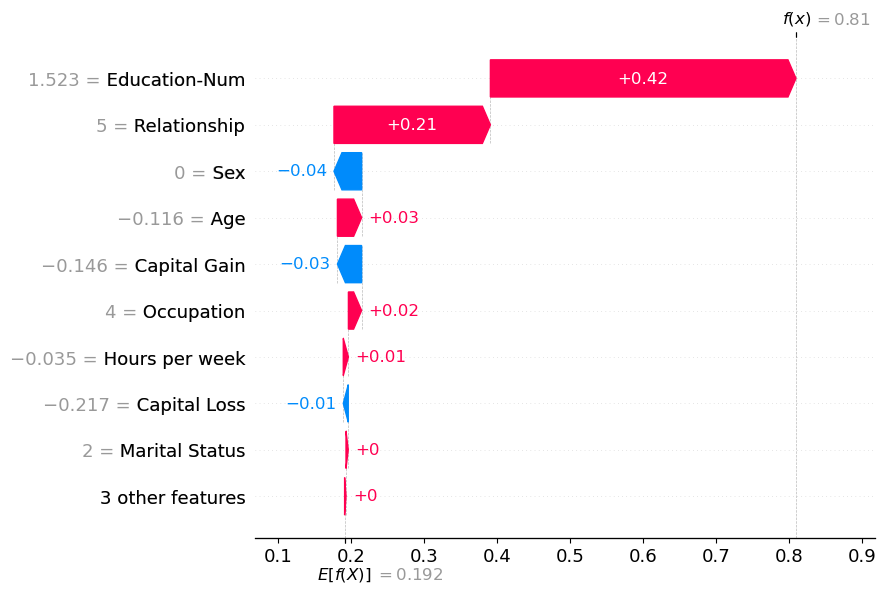

In [19]:
waterfall(exp[0])

# Iso Forest

In [20]:
# build and fit the model
model = IsolationForest(max_features=0.5,random_state=1, n_estimators=100)
model.fit(X.iloc[:200,:])

IsolationForest(max_features=0.5, random_state=1)

In [21]:
# get the explainer
explainer = shap.TreeExplainer(model)

In [22]:
# test one value
test = X.iloc[[300],:]
shap_values = explainer.shap_values(test)

In [23]:
explainer.expected_value

array([11.62942206])

In [24]:
shap_values

array([[ 0.0874149 ,  0.37951468, -0.09238503,  0.29295728, -0.52324038,
         0.24320473,  0.21189215,  0.21173184, -1.20540123,  0.12523524,
         0.28663784,  0.23870752]])

In [25]:
shap.force_plot(explainer.expected_value, shap_values, test)

In [26]:
# test all dataset
shap_values_all_iso = explainer.shap_values(X)

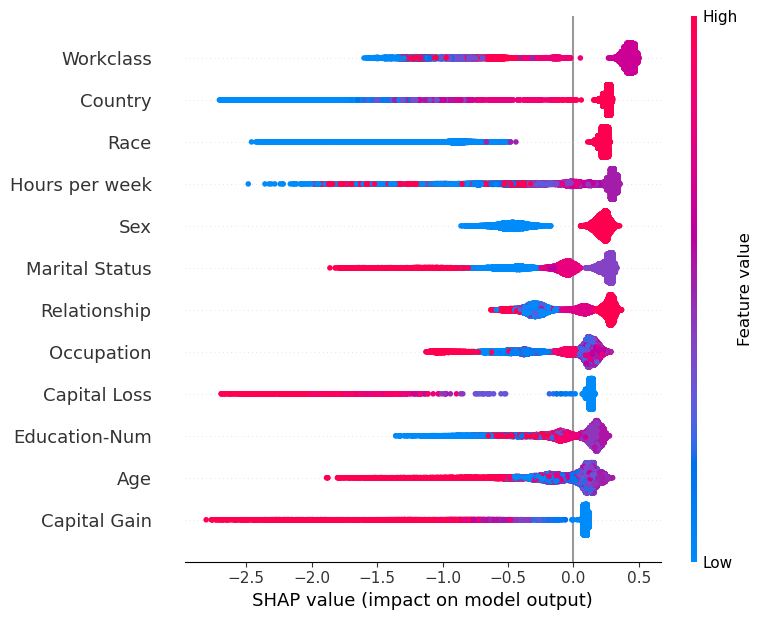

In [27]:
shap.summary_plot(shap_values_all_iso, X)

In [30]:
# force plot it
shap.force_plot(explainer.expected_value, shap_values_all_iso[:50,:], X.iloc[:50,:])

In [31]:
# now with the wrapper class
w_explainer = isoe.IsolationForestExplainer(model)

In [32]:
shap_values, expected_value = w_explainer.get_explanation(X.iloc[:50,:])

In [33]:
w_explainer.get_force_plot(X.iloc[:50,:],shap_values[:50,:])

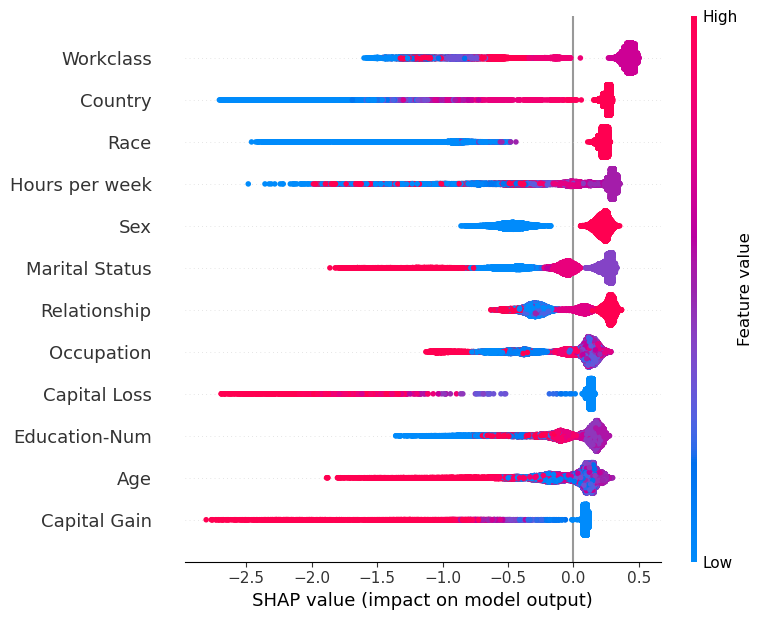

In [34]:
w_explainer.get_summary_plot(X,shap_values_all_iso)